<a href="https://colab.research.google.com/github/YanivAmir/stock-predicition-CNN/blob/main/loading_uniting_and_downsampling_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import yfinance as yf
# import yahoo_fin.stock_info as si
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
# import mplfinance as mpf
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import itertools
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
import torch.cuda.amp as amp
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
loadPath ='/content/drive/MyDrive/myStocksSept2024/'
savePath ='/content/drive/MyDrive/myStocksSept2024/unitedData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
fileIndices1 = [0,30,60,90,120,151,181,211,241,272,302,332,362,392,423,453,483,500]
fileIndices2 = [500,530,560,590,621,651,681,711,741,772,802,832,862,892,923,953,983,1000]
fileIndices3 = [1000,1030,1060,1090,1121,1151,1181,1212,1242,1272,1302,1333,1363,1393,1423,1454,1484,1500]
fileIndices4 = [1500,1530,1560,1590,1620,1651,1681,1711]
fileIndices5 = [1711,1742,1772,1802,1832,1862,1893,1923,1953,1983,2000]
fileIndices6 = [2000,2030,2060,2090,2121,2151,2181,2212,2242,2272,2302,2333,2363,2393,2423,2454,2484,2500]
fileIndices7 = [2500,2530,2560,2590,2620,2651,2681,2711,2741,2772,2802,2832,2862,2893,2923,2953,2983,3000]
fileIndices8 = [3000,3030,3060,3090,3121,3151,3181,3211,3242,3272,3302,3315]

In [11]:
def loadPlotFile(path, name,strt,end):
  data = np.load(path+name+'_asList_'+str(strt)+'-'+str(end)+'_24Sept2024.npz',allow_pickle=True)
  data_array = np.array([data[key] for key in data])
  return(torch.from_numpy(data_array).half())

def loadTargetFile(path,strt,end):
  data = np.load(path+'TargetsData_asList_'+str(strt)+'-'+str(end)+'_24Sept2024.npz',allow_pickle=True)
  df = pd.DataFrame([data[key] for key in data],columns=['ticker','plotRangeStartDate','plotRangeEndDate','targetDate','predictionClose','plotRangeClose','target'])
  return(df)

def loadData(path,strts,pool=1):
  images_list = []
  targetsData = pd.DataFrame(columns=['ticker','plotRangeStartDate','plotRangeEndDate','targetDate','predictionClose','plotRangeClose','target'])
  for strt,end in zip(strts[:-1],strts[1:]):
    print(strt,end='  ')
    candlestickPlots = F.avg_pool2d(loadPlotFile(path,'CandlesticksImgs',strt,end),pool)
    capPlots = F.avg_pool2d(loadPlotFile(path,'CapImgs',strt,end),pool)
    images = torch.cat((candlestickPlots.unsqueeze(1), capPlots.unsqueeze(1)), dim=1)
    currentTargetData = loadTargetFile(path,strt,end)
    images_list.append(images)
    targetsData = pd.concat([targetsData,currentTargetData],axis=0)
  images = torch.cat((images_list), dim=0)
  return(images,targetsData)

In [12]:
for idx in [fileIndices1,fileIndices2,fileIndices3,fileIndices4,fileIndices5,fileIndices6,fileIndices7,fileIndices8]:
  images,targetsData= loadData(loadPath,idx,pool=3)
  torch.save(images, savePath+f'images_tickers{int(idx[0])}-{int(idx[-1])}_pool3_asHalf.pt')
  torch.save(targetsData,savePath+f'targets_tickers{int(idx[0])}-{int(idx[-1])}_pool3_asDf.pt')
  print(f'\nImages sizes after uniting data : {images.shape}')
  print(f'Targets sizes after uniting data : {targetsData.shape}\n')
  del images,targetsData


1711  1742  1772  1802  1832  1862  1893  1923  1953  1983  
Images sizes after uniting data : torch.Size([28588, 2, 120, 120])
Targets sizes after uniting data : (28588, 7)

2000  2030  2060  2090  2121  2151  2181  2212  2242  2272  2302  2333  2363  2393  2423  2454  2484  
Images sizes after uniting data : torch.Size([49532, 2, 120, 120])
Targets sizes after uniting data : (49532, 7)

2500  2530  2560  2590  2620  2651  2681  2711  2741  2772  2802  2832  2862  2893  2923  2953  2983  
Images sizes after uniting data : torch.Size([49604, 2, 120, 120])
Targets sizes after uniting data : (49604, 7)

3000  3030  3060  3090  3121  3151  3181  3211  3242  3272  3302  
Images sizes after uniting data : torch.Size([31311, 2, 120, 120])
Targets sizes after uniting data : (31311, 7)



In [3]:
saveIndices = [0,500,1000,1500,1711,2000,2500,3000,3315]
for i in range(6):
  images = None
  for strtIndx,endIdx in zip(saveIndices[:-1],saveIndices[1:]):
    currentImgs = torch.load(savePath+f'images_tickers{strtIndx}-{endIdx}_pool3_asHalf.pt')[i::6]
    currentTargets = torch.load(savePath+f'targets_tickers{strtIndx}-{endIdx}_pool3_asDf.pt')[i::6]

    if images is None:
        images = currentImgs  # First batch
        targets = currentTargets
    else:
        images = torch.cat((images, currentImgs), dim=0)
        targets = pd.concat([targets,currentTargets],axis=0)
    del currentImgs
    print(images.shape)

  torch.save(images, savePath+f'images_tickers0-3315_[{str(i)}::6]_pool3_asHalf.pt')
  pd.to_pickle(targets,savePath+f'targets_tickers0-3315_[{str(i)}::6]_pool3_asDf.pkl')
  print(f'Images sizes after uniting [{i}::6] data : {images.shape}')
  print(f'Targets sizes after uniting [{i}::6] data : {targets.shape}')


torch.Size([8270, 2, 120, 120])
torch.Size([16537, 2, 120, 120])
torch.Size([24796, 2, 120, 120])
torch.Size([28296, 2, 120, 120])
torch.Size([33061, 2, 120, 120])
torch.Size([41317, 2, 120, 120])
torch.Size([49585, 2, 120, 120])
torch.Size([54804, 2, 120, 120])
Images sizes after uniting [0::6] data : torch.Size([54804, 2, 120, 120])
Targets sizes after uniting [0::6] data : (54804, 7)
torch.Size([8270, 2, 120, 120])
torch.Size([16537, 2, 120, 120])
torch.Size([24796, 2, 120, 120])
torch.Size([28296, 2, 120, 120])
torch.Size([33061, 2, 120, 120])
torch.Size([41317, 2, 120, 120])
torch.Size([49585, 2, 120, 120])
torch.Size([54804, 2, 120, 120])
Images sizes after uniting [1::6] data : torch.Size([54804, 2, 120, 120])
Targets sizes after uniting [1::6] data : (54804, 7)
torch.Size([8270, 2, 120, 120])
torch.Size([16537, 2, 120, 120])
torch.Size([24796, 2, 120, 120])
torch.Size([28296, 2, 120, 120])
torch.Size([33061, 2, 120, 120])
torch.Size([41316, 2, 120, 120])
torch.Size([49583, 2, 1

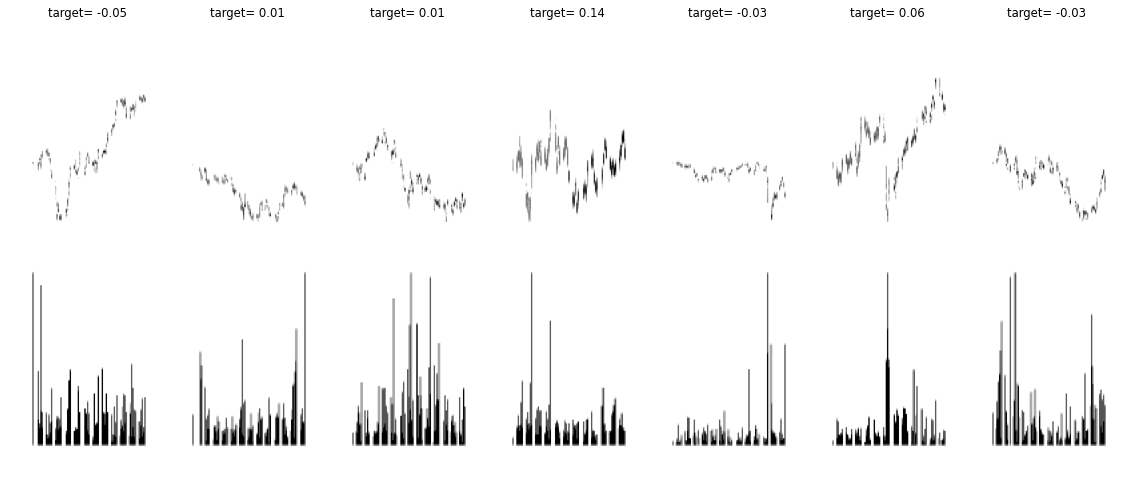

In [17]:
# visualize some images
fig,axs = plt.subplots(2,7,figsize=(5*320/100,2*320/100),dpi=70)

for i in range(axs.shape[1]):

  # pick a random pic
  n = random.randint(0,images.shape[0]-1)

  # visualize
  axs[0,i].imshow(images[n,0,:,:],cmap='gray', aspect='auto')
  axs[1,i].imshow(images[n,1,:,:],cmap='gray', aspect='auto')
  axs[0,i].set_title(f'target= {round(targets.iloc[n,-1],2)}')
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()